In [1]:
# Imports
import os
import warnings
import logging
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

/mnt/d/ML/Projects/smart-face-recognition-attendance-system/facenet-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-15 10:38:47.652328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752575927.715333    7592 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752575927.734655    7592 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752575927.853189    7592 computation_placer.cc:177] computation placer already registered. Please check linkage and av

In [2]:
# Config
MODEL_NAME = "google/vit-base-patch16-224"
DATA_ROOT = "../emotions_data"
MODEL_SAVE_PATH = "saved_model/vit_emotion_head.pth"
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-4
PATIENCE = 3

EMOTION_CLASSES = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Accept grayscale but convert to 3-channel
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset
full_dataset = ImageFolder(DATA_ROOT, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
# Model
class EmotionClassifier(nn.Module):
    def __init__(self, vit, num_classes, dropout=0.4):
        super().__init__()
        self.vit = vit
        self.dropout = nn.Dropout(dropout)
        self.emotion_head = nn.Sequential(
            nn.Linear(vit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.vit(pixel_values=x).last_hidden_state[:, 0]
        x = self.dropout(x)
        return self.emotion_head(x)

In [5]:
# Class weights
all_labels = [label for _, label in train_dataset]
class_counts = [all_labels.count(i) for i in range(len(EMOTION_CLASSES))]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * len(EMOTION_CLASSES)

# Load and partially freeze ViT
vit = ViTModel.from_pretrained(MODEL_NAME)
for param in vit.parameters():
    param.requires_grad = False
for name, param in vit.named_parameters():
    if any(f"encoder.layer.{i}" in name for i in [10, 11]):
        param.requires_grad = True

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Initialize model
model = EmotionClassifier(vit, num_classes=len(EMOTION_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

In [7]:
# Training loop
best_val_acc = 0
patience_counter = 0
train_losses, val_accuracies = [], []
min_delta = 0.1

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    acc = 100 * correct / len(train_dataset)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = 100 * val_correct / len(val_dataset)
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_acc)

    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Saved improved model at Epoch {epoch+1}")
    else:
        patience_counter += 1
        print(f"No significant improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered due to validation accuracy plateau.")
            break

Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:35<00:00,  1.42s/it]


Train Loss: 1.3757, Accuracy: 49.98%
Validation Accuracy: 57.73%
Saved improved model at Epoch 1


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:27<00:00,  1.40s/it]


Train Loss: 1.1093, Accuracy: 58.46%
Validation Accuracy: 60.03%
Saved improved model at Epoch 2


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:20<00:00,  1.38s/it]


Train Loss: 1.0117, Accuracy: 61.58%
Validation Accuracy: 61.55%
Saved improved model at Epoch 3


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [11:05<00:00,  1.48s/it]


Train Loss: 0.9276, Accuracy: 64.29%
Validation Accuracy: 61.05%
No significant improvement. Patience: 1/3


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:20<00:00,  1.38s/it]


Train Loss: 0.8686, Accuracy: 66.45%
Validation Accuracy: 64.31%
Saved improved model at Epoch 5


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [11:32<00:00,  1.54s/it]


Train Loss: 0.8124, Accuracy: 68.26%
Validation Accuracy: 63.92%
No significant improvement. Patience: 1/3


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [11:42<00:00,  1.57s/it]


Train Loss: 0.7574, Accuracy: 70.01%
Validation Accuracy: 65.77%
Saved improved model at Epoch 7


Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:06<00:00,  1.35s/it]


Train Loss: 0.7156, Accuracy: 71.53%
Validation Accuracy: 66.47%
Saved improved model at Epoch 8


Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████| 449/449 [10:03<00:00,  1.34s/it]


Train Loss: 0.6667, Accuracy: 73.42%
Validation Accuracy: 65.76%
No significant improvement. Patience: 1/3


Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████| 449/449 [10:03<00:00,  1.34s/it]


Train Loss: 0.6340, Accuracy: 74.58%
Validation Accuracy: 66.23%
No significant improvement. Patience: 2/3


Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████| 449/449 [10:03<00:00,  1.34s/it]


Train Loss: 0.5921, Accuracy: 76.30%
Validation Accuracy: 65.99%
No significant improvement. Patience: 3/3
Early stopping triggered due to validation accuracy plateau.


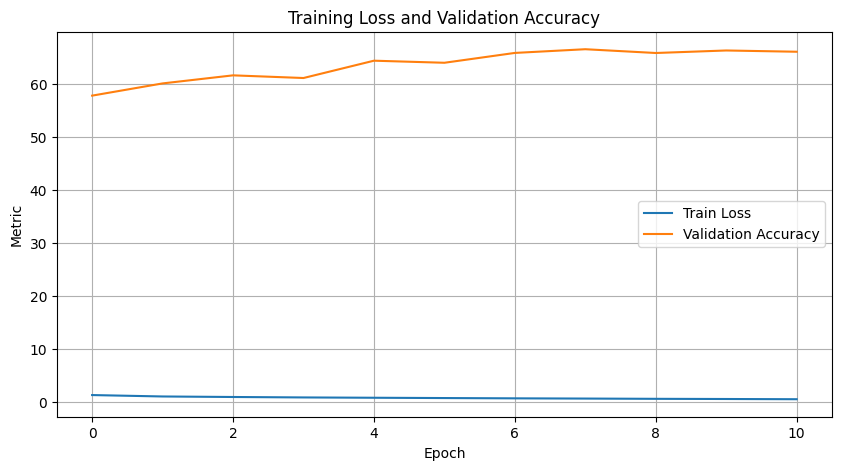

In [8]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Evaluation
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=EMOTION_CLASSES))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.55      0.58      1030
     Disgust       0.64      0.67      0.65       102
        Fear       0.58      0.42      0.48      1046
       Happy       0.86      0.84      0.85      1761
     Neutral       0.59      0.67      0.63      1242
         Sad       0.51      0.61      0.56      1200
    Surprise       0.75      0.79      0.77       797

    accuracy                           0.66      7178
   macro avg       0.65      0.65      0.65      7178
weighted avg       0.66      0.66      0.66      7178



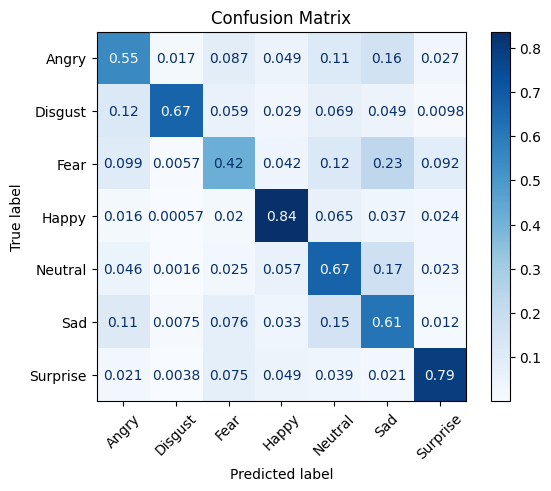

In [10]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EMOTION_CLASSES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

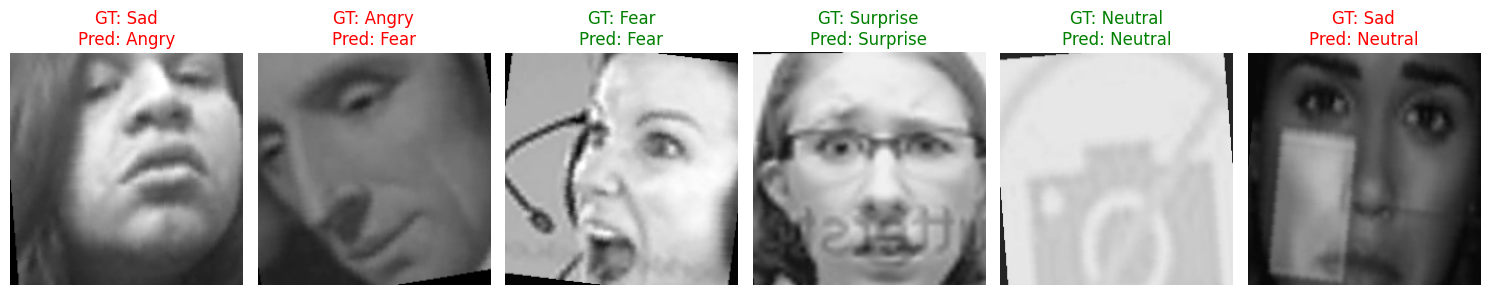

Training complete. Best model saved to saved_model/vit_emotion_head.pth


In [11]:
# Visualize predictions
def show_predictions(model, dataset, num=6):
    model.eval()
    fig, axes = plt.subplots(1, num, figsize=(15, 3))
    for i in range(num):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
        axes[i].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        axes[i].set_title(f"GT: {EMOTION_CLASSES[label]}\nPred: {EMOTION_CLASSES[pred]}",
                          color='green' if label == pred else 'red')
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, val_dataset)
print(f"Training complete. Best model saved to {MODEL_SAVE_PATH}")